# Done

1. Implemented random walker configurations
2. Make my python files in the form of package like pyqmc
3. Replaced Cupy with JAX for GPU computations (Cupy not supported on Mac)
4. Calculated wave functions using random walk configurations

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pyscf import gto, scf
from qmc.extract import pyscf_parameter
from qmc.mc import np_initial_guess
from qmc.determinant_tools import orbital_from_pyscf

# STEP 1. Random Walk Implementation

A random walk is a mathematical process that describes a path consisting of a succession of random steps. 

1. **Initialize Parameters**: Define the number of steps, dimensions, and other parameters required for the random walk.
2. **Generate Random Steps**: Use a random number generator to create steps in each dimension.
3. **Calculate Positions**: Compute the position at each step by cumulatively adding the random steps.
4. **Visualize the Path**: Plot the resulting path to visualize the random walk.


In [2]:
mol = gto.Mole()

mol.atom = '''
O 0.000000 0.000000 0.117790
H 0.000000 0.755453 -0.471161
H 0.000000 -0.755453 -0.471161
'''
mol.basis = 'sto-3g'

mol.build()
mf = scf.RHF(mol)
mf.kernel()

converged SCF energy = -74.963146775618


np.float64(-74.96314677561796)

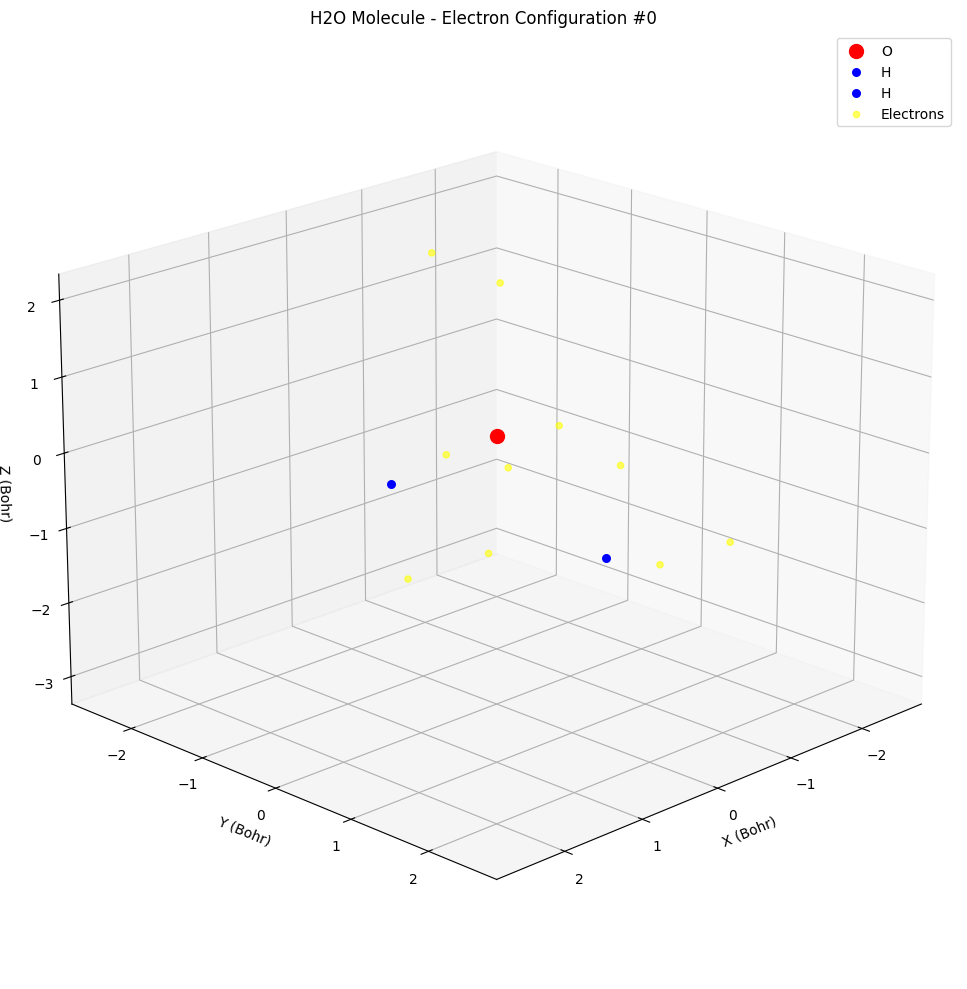

In [3]:
configs = np_initial_guess(mol, 1000)

def visualize_h2o_config(mol, configs, config_idx=0):
 
    atoms = mol.atom_coords()
    atom_symbols = [atom[0] for atom in mol._atom]
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    colors = {'O': 'red', 'H': 'blue'}
    sizes = {'O': 100, 'H': 30}
    
    for atom, symbol in zip(atoms, atom_symbols):
        ax.scatter(*atom, c=colors[symbol], s=sizes[symbol], label=symbol)
    
    electron_positions = configs[config_idx]  # shape: (nelec, 3)
    ax.scatter(electron_positions[:, 0], 
              electron_positions[:, 1], 
              electron_positions[:, 2],
              c='yellow', s=20, alpha=0.6, label='Electrons')
    
    ax.set_xlabel('X (Bohr)')
    ax.set_ylabel('Y (Bohr)')
    ax.set_zlabel('Z (Bohr)')
    ax.legend()
    
    ax.view_init(elev=20, azim=45)
    
    max_range = max(
        np.ptp(atoms[:, 0]),
        np.ptp(atoms[:, 1]),
        np.ptp(atoms[:, 2])
    ) * 2
    
    ax.set_xlim(atoms[:, 0].mean() - max_range/2, atoms[:, 0].mean() + max_range/2)
    ax.set_ylim(atoms[:, 1].mean() - max_range/2, atoms[:, 1].mean() + max_range/2)
    ax.set_zlim(atoms[:, 2].mean() - max_range/2, atoms[:, 2].mean() + max_range/2)
    
    plt.title(f'H2O Molecule - Electron Configuration #{config_idx}')
    plt.tight_layout()
    plt.show()

visualize_h2o_config(mol, configs)


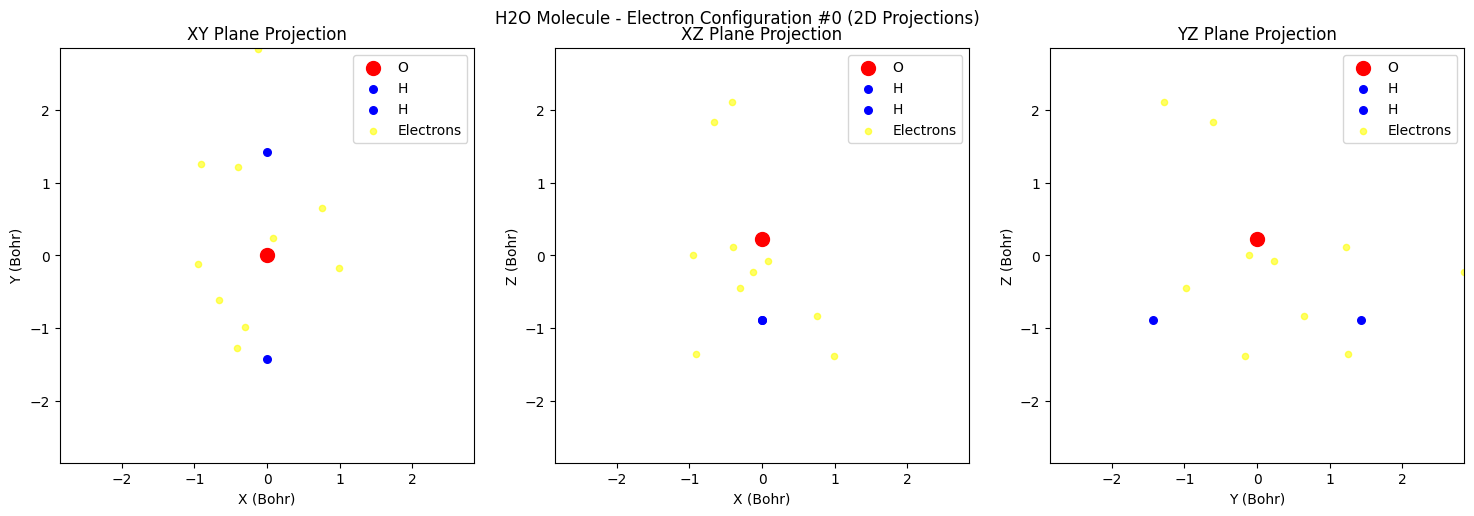

In [4]:
def visualize_h2o_config_2d(mol, configs, config_idx=0):
    atoms = mol.atom_coords()
    atom_symbols = [atom[0] for atom in mol._atom]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    colors = {'O': 'red', 'H': 'blue'}
    sizes = {'O': 100, 'H': 30}
    
    # XY plane projection
    for atom, symbol in zip(atoms, atom_symbols):
        ax1.scatter(atom[0], atom[1], c=colors[symbol], s=sizes[symbol], label=symbol)
    
    electron_positions = configs[config_idx]
    ax1.scatter(electron_positions[:, 0], 
                electron_positions[:, 1],
                c='yellow', s=20, alpha=0.6, label='Electrons')
    
    ax1.set_xlabel('X (Bohr)')
    ax1.set_ylabel('Y (Bohr)')
    ax1.set_title('XY Plane Projection')
    
    # XZ plane projection
    for atom, symbol in zip(atoms, atom_symbols):
        ax2.scatter(atom[0], atom[2], c=colors[symbol], s=sizes[symbol], label=symbol)
    
    ax2.scatter(electron_positions[:, 0], 
                electron_positions[:, 2],
                c='yellow', s=20, alpha=0.6, label='Electrons')
    
    ax2.set_xlabel('X (Bohr)')
    ax2.set_ylabel('Z (Bohr)')
    ax2.set_title('XZ Plane Projection')
    
    # YZ plane projection
    for atom, symbol in zip(atoms, atom_symbols):
        ax3.scatter(atom[1], atom[2], c=colors[symbol], s=sizes[symbol], label=symbol)
    
    ax3.scatter(electron_positions[:, 1], 
                electron_positions[:, 2],
                c='yellow', s=20, alpha=0.6, label='Electrons')
    
    ax3.set_xlabel('Y (Bohr)')
    ax3.set_ylabel('Z (Bohr)')
    ax3.set_title('YZ Plane Projection')
    
    # Set equal aspect ratios and limits for all subplots
    for ax in [ax1, ax2, ax3]:
        ax.set_aspect('equal')
        ax.legend()
        
        max_range = max(
            np.ptp(atoms[:, 0]),
            np.ptp(atoms[:, 1]),
            np.ptp(atoms[:, 2])
        ) * 2
        
        ax.set_xlim(atoms[:, 0].mean() - max_range/2, atoms[:, 0].mean() + max_range/2)
        ax.set_ylim(atoms[:, 1].mean() - max_range/2, atoms[:, 1].mean() + max_range/2)
    
    plt.suptitle(f'H2O Molecule - Electron Configuration #{config_idx} (2D Projections)')
    plt.tight_layout()
    plt.show()

# 함수 실행
visualize_h2o_config_2d(mol, configs)

In [20]:
detcoeff, occup, det_map, orbital = orbital_from_pyscf(mol, mf)

In [21]:
nelec_spin = mol.nelec
nconf, nelec, ndim = configs.shape

# FIRST 
# aos value: φᵢ(r) = R(r)Y_lm(θ,φ)
# R(R): radial part, Y_lm(θ,φ): spherical harmonic
# eval_str
# (1) 'GTOval' : Evaluate the value of GTOs
# (2) 'GTOval_ip' : Evaluate the value of GTOs and their first derivatives
#     ∂φ/∂x, ∂φ/∂y, ∂φ/∂z 반환
# (3) 'GTOval_ip_ip' : Evaluate the value of GTOs and their first and second derivatives
#     ∂²φ/∂x², ∂²φ/∂y², ∂²φ/∂z², ∂²φ/∂x∂y, ∂²φ/∂x∂z, ∂²φ/∂y∂z 반환

eval_str = "GTOval"
aos = orbital.aos(eval_str, configs)
print(aos.shape)
aovals = aos.reshape(-1, nconf, nelec, aos.shape[-1])
print(aovals.shape)

(1, 10000, 7)
(1, 1000, 10, 7)


In [51]:
# s = 0 (up spin) calculation
# Calculate which molecular orbitals are occupied by electrons
# Upper half of the system's electrons (up spin)
s = 0

# Set range for up spin electrons using begin, end
begin = nelec_spin[0] * s  # 0
end = nelec_spin[0] + nelec_spin[1] * s  # 5

# Get MO coefficients (for alpha electrons)
parameter = jnp.array(orbital.parameters[orbital.parm_names[s]])

# MO calculation: Ψⱼ(r) = Σᵢ cᵢⱼ φᵢ(r)
# Create molecular orbitals as linear combinations of atomic orbitals
mo = jnp.dot(aovals[:, :, begin:end :][0], parameter)
print("Up spin MO shape:", mo.shape)  # (1000, 5, 5)

# Transform into Slater matrix form
# [Ψ₁(r₁) Ψ₁(r₂) Ψ₁(r₃)] |Ψ₁(r₁) Ψ₂(r₁) Ψ₃(r₁)|
# [Ψ₂(r₁) Ψ₂(r₂) Ψ₂(r₃)] -> |Ψ₁(r₂) Ψ₂(r₂) Ψ₃(r₂)|
# [Ψ₃(r₁) Ψ₃(r₂) Ψ₃(r₃)] |Ψ₁(r₃) Ψ₂(r₃) Ψ₃(r₃)|
mo_vals = jnp.swapaxes(mo[:, :, occup[s]], 1, 2)
print("Up spin Slater matrix shape:", mo_vals.shape)

# Calculate Slater determinant
det_val = jnp.linalg.slogdet(mo_vals)
print(f"Up spin determinant shape: {det_val[0].shape}, {det_val[1].shape}")

# Why det_map[0] is [[0], [0]]:
# 1. Computing single determinant (not multi-determinant)
# 2. First [0]: Select determinant from first configuration
# 3. Second [0]: Use only first determinant from that configuration
# if siutation becomes more complex, the detrminant might be as follows: Ψ = c₁det₁ + c₂det₂ + c₃det₃
updets = det_val[0][:, det_map[0]], det_val[1][:, det_map[0]]
print("Up spin mapped determinants:", )

# s = 1 (down spin) calculation
# Lower half of system's electrons (down spin)
s = 1
begin = nelec_spin[0] * s  # 5
end = nelec_spin[0] + nelec_spin[1] * s  # 10

# Get MO coefficients (for beta electrons)
parameter = jnp.array(orbital.parameters[orbital.parm_names[s]])

# Calculate MO for down spin
mo = jnp.dot(aovals[:, :, begin:end :][0], parameter)
print("\nDown spin MO shape:", mo.shape)

# Transform into Slater matrix form
mo_vals = jnp.swapaxes(mo[:, :, occup[s]], 1, 2)
print("Down spin Slater matrix shape:", mo_vals.shape)

# Calculate down spin determinant
det_val = jnp.linalg.slogdet(mo_vals)
print(f"Down spin determinant shape: {det_val[0].shape}, {det_val[1].shape}")

# det_map[1] is also [[0], [0]]
# Same reason as up spin - selecting single determinant
dndets = det_val[0][:, det_map[1]], det_val[1][:, det_map[1]]
print("Down spin mapped determinants:",)

# Overall reason why det_map is [[0], [0]]:
# 1. This indicates HF (Hartree-Fock) level calculation
# 2. Using single Slater determinant (most basic approximation)
# 3. More accurate calculations require multiple determinants
# (Methods like CI, MCSCF would have more complex det_map)
# Final wave function is:
# Ψ = det(up) × det(down)
# Check for zero wave functions (up spin)
# Check for zero wave functions (up spin)

# Store results
dets = [updets, dndets]
# Calculate final wave function
# Ψ = det(up) × det(down)
# ln|Ψ| = ln|det(up)| + ln|det(down)|
phase = dets[0][0] * dets[1][0]  # multiply signs
logdet = dets[0][1] + dets[1][1]  # add logdets

print("\nFinal wave function components:")
print(f"Phase shape: {phase.shape}")
print(f"Logdet shape: {logdet.shape}")

Up spin MO shape: (1000, 5, 5)
Up spin Slater matrix shape: (1000, 1, 5, 5)
Up spin determinant shape: (1000, 1), (1000, 1)
Up spin mapped determinants:

Down spin MO shape: (1000, 5, 5)
Down spin Slater matrix shape: (1000, 1, 5, 5)
Down spin determinant shape: (1000, 1), (1000, 1)
Down spin mapped determinants:

Final wave function components:
Phase shape: (1000, 1)
Logdet shape: (1000, 1)


## Ongoing

1. **Inverse matrix**: Change it into Jax's preferred form.
2. **Metropolis-hasting algorithm**: Estimate the wave function while moving the electron position (like rejection sampling and baysian optimization --> MCMC)
3. **Optimize the value of each parameters**
4. **Paralleziation**

## Problem
1. Jax is not compatiable with class self object

# Investigation of the relationship between the distasnce and energies of RHF and VMC

In [60]:
import pyscf
import pyqmc.api as pyq
import numpy as np
import pyscf.mcscf
import matplotlib.pyplot as plt 
from pyscf.pbc import gto, scf

def calculate_energy_vs_distance(distances):
    rhf_energies = []
    casscf_energies = []
    opt_energies = []
    
    for d in distances:
        mol = pyscf.gto.M(
            atom=f'H 0 0 0; H 0 0 {d}',
            ecp="ccecp",
            basis="ccecpccpvdz",
            unit="bohr",
            verbose=0
        )
        
        # 1. RHF
        mf = pyscf.scf.RHF(mol)
        rhf_energy = mf.kernel()
        rhf_energies.append(rhf_energy)
        
        # 2. CASSCF
        mc = pyscf.mcscf.CASSCF(mf, 2, 2)
        casscf_energy = mc.kernel()[0]
        casscf_energies.append(casscf_energy)
        
        # 3. Wave function optimization
        wf, to_opt = pyq.generate_wf(mol, mf, mc=mc)
        grad = pyq.gradient_generator(mol, wf, to_opt)
        coords = pyq.initial_guess(mol, 5000)
        wf, data = pyq.line_minimization(wf, coords, grad, verbose=True, max_iterations=10)
        
        energy_values = [step['en'] for step in data if 'en' in step]
        opt_energy = energy_values[-1] if energy_values else None
        opt_energies.append(opt_energy)
        
    
    return rhf_energies, casscf_energies, opt_energies

distances = np.linspace(0.5, 5.0, 10)

rhf_e, casscf_e, opt_e = calculate_energy_vs_distance(distances)

starting warmup
finished warmup
----------vmc done
descent en -0.4536292256646249 0.0011056160134876065  estimated sigma  0.781788580525524
descent |grad| 0.26845936428376604
----------vmc done
descent en -0.5006440711494642 0.0009336983706733676  estimated sigma  0.6602244494859689
descent |grad| 0.06592846324683817
----------vmc done
descent en -0.5066188477996717 0.001129273737539706  estimated sigma  0.7985171176302037
descent |grad| 0.025556502834413835
----------vmc done
descent en -0.5043204530104356 0.0006408595780105947  estimated sigma  0.4531561533996408
descent |grad| 0.018028670676430356
----------vmc done
descent en -0.5047009005133426 0.0007713027113224836  estimated sigma  0.5453933775236983
descent |grad| 0.014786071436998022
----------vmc done
descent en -0.5078387658322974 0.0011958260269551828  estimated sigma  0.8455766927793769
descent |grad| 0.016084178746246354
----------vmc done
descent en -0.5061054674328432 0.0007176885998825902  estimated sigma  0.5074824757

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(distances, rhf_e, 'o-', label='RHF')
plt.plot(distances, casscf_e, 's-', label='CASSCF')
plt.plot(distances, opt_e, '^-', label='WF Opt')
plt.xlabel('H-H Distance (Bohr)')
plt.ylabel('Energy (Hartree)')
plt.title('H2 Dissociation Curves')
plt.legend()
plt.grid(True)
plt.show()